# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Load data

In [ ]:
url = """D:/Foundations_of_DataScience/Projects/Final_projects/lending_club_dataset_2007_2020/lending_club_clean.feather"""
data = pd.read_feather(url)
# data = pd.read_csv(url)

# Initial inspection

In [ ]:
columns_to_remove = [
    "hardship_type",
    "hardship_reason",
    "hardship_status",
    "hardship_start_date",
    "hardship_end_date",
    "payment_plan_start_date",
    "hardship_loan_status",
    "verification_status_joint",
    "sec_app_earliest_cr_line",
    "next_pymnt_d",
    "earliest_cr_line",
    "last_credit_pull_d",
    "revol_util"
]
data = data.drop(columns=columns_to_remove)
print(data.columns)

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title',
       ...
       'sec_app_collections_12_mths_ex_med', 'hardship_flag', 'deferral_term',
       'hardship_amount', 'hardship_length', 'hardship_dpd',
       'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag'],
      dtype='object', length=128)


In [ ]:
missing_values = data.isnull().sum()
missing_columns = missing_values[missing_values > 0]

print("Columns with missing values and their counts:")
print(missing_columns)

Columns with missing values and their counts:
emp_title        264086
emp_length       205220
title             23325
zip_code              1
last_pymnt_d       4921
hardship_flag     38435
dtype: int64


In [ ]:
print("Basic Statistics:\n", data.describe(include='all'))

Basic Statistics:
                      id     loan_amnt   funded_amnt  funded_amnt_inv  \
count         2925492.0     2925492.0     2925492.0     2.925492e+06   
unique             <NA>          <NA>          <NA>              NaN   
top                <NA>          <NA>          <NA>              NaN   
freq               <NA>          <NA>          <NA>              NaN   
mean    97829692.164153  15358.775105  15354.704909     1.534005e+04   
min             54734.0         500.0         500.0     0.000000e+00   
25%          59131974.0        8000.0        8000.0     8.000000e+03   
50%         107610658.5       13000.0       13000.0     1.300000e+04   
75%        143220179.75       20000.0       20000.0     2.000000e+04   
max         171017115.0       40000.0       40000.0     4.000000e+04   
std     51163328.917654   9478.383451   9477.144689     9.469948e+03   

             term      int_rate   installment    grade sub_grade emp_title  \
count   2925492.0  2.925492e+06  2.925

In [ ]:
data=data[(~data['emp_length'].isna()) & (~data['emp_title'].isna())].copy()

In [ ]:
data = data.dropna(subset=['zip_code'])

# Fill missing values for simplicity

In [ ]:
numerical_cols = data.select_dtypes(include=['number']).columns
categorical_cols = data.select_dtypes(include=['object', 'category']).columns

In [ ]:
numerical_imputer = SimpleImputer(strategy='mean')
data[numerical_cols] = numerical_imputer.fit_transform(data[numerical_cols])

In [ ]:
categorical_imputer = SimpleImputer(strategy='most_frequent')
data[categorical_cols] = categorical_imputer.fit_transform(data[categorical_cols])

# Convert categorical columns to numeric

In [ ]:
categorical_cols = data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    data[col] = pd.factorize(data[col])[0]

### Exploratory Data Analysis (EDA)

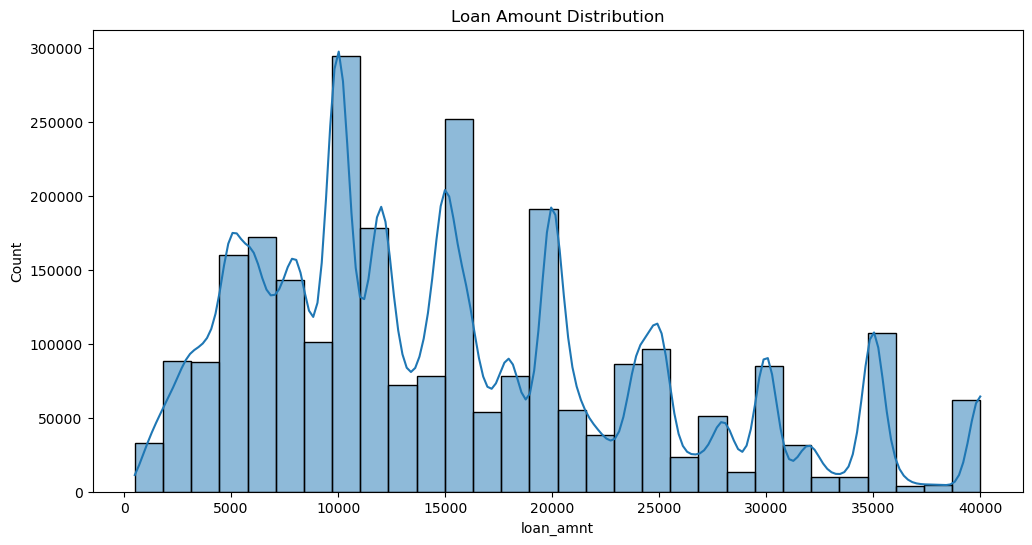

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(data['loan_amnt'], kde=True, bins=30)
plt.title("Loan Amount Distribution")
plt.show()

# Correlation heatmap

Highly correlated features with 'loan_status':
loan_status      1.000000
out_prncp        0.699804
out_prncp_inv    0.699758
id               0.635799
issue_d          0.625738
Name: loan_status, dtype: float64


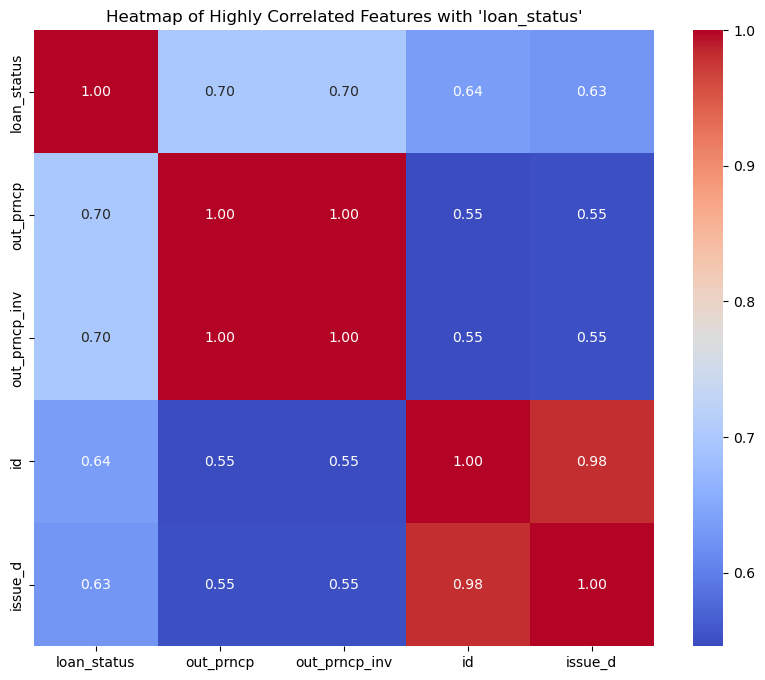

In [ ]:
correlation = data.corr()
threshold = 0.5 
loan_status_correlation = correlation["loan_status"].abs()
highly_correlated = loan_status_correlation[loan_status_correlation > threshold].sort_values(ascending=False)
print("Highly correlated features with 'loan_status':")
print(highly_correlated)

high_corr_features = highly_correlated.index.tolist()
plt.figure(figsize=(10, 8))
sns.heatmap(data[high_corr_features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap of Highly Correlated Features with 'loan_status'")
plt.show()

# Overall features

Columns kept (highly correlated): ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'issue_d', 'fico_range_low', 'fico_range_high', 'open_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'recoveries', 'collection_recovery_fee', 'application_type', 'dti_joint', 'tot_cur_bal', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 'num_sats', 'tot_hi_cred_lim', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_open_acc', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'deferral_term', 'hardship_length', 'loan_status']


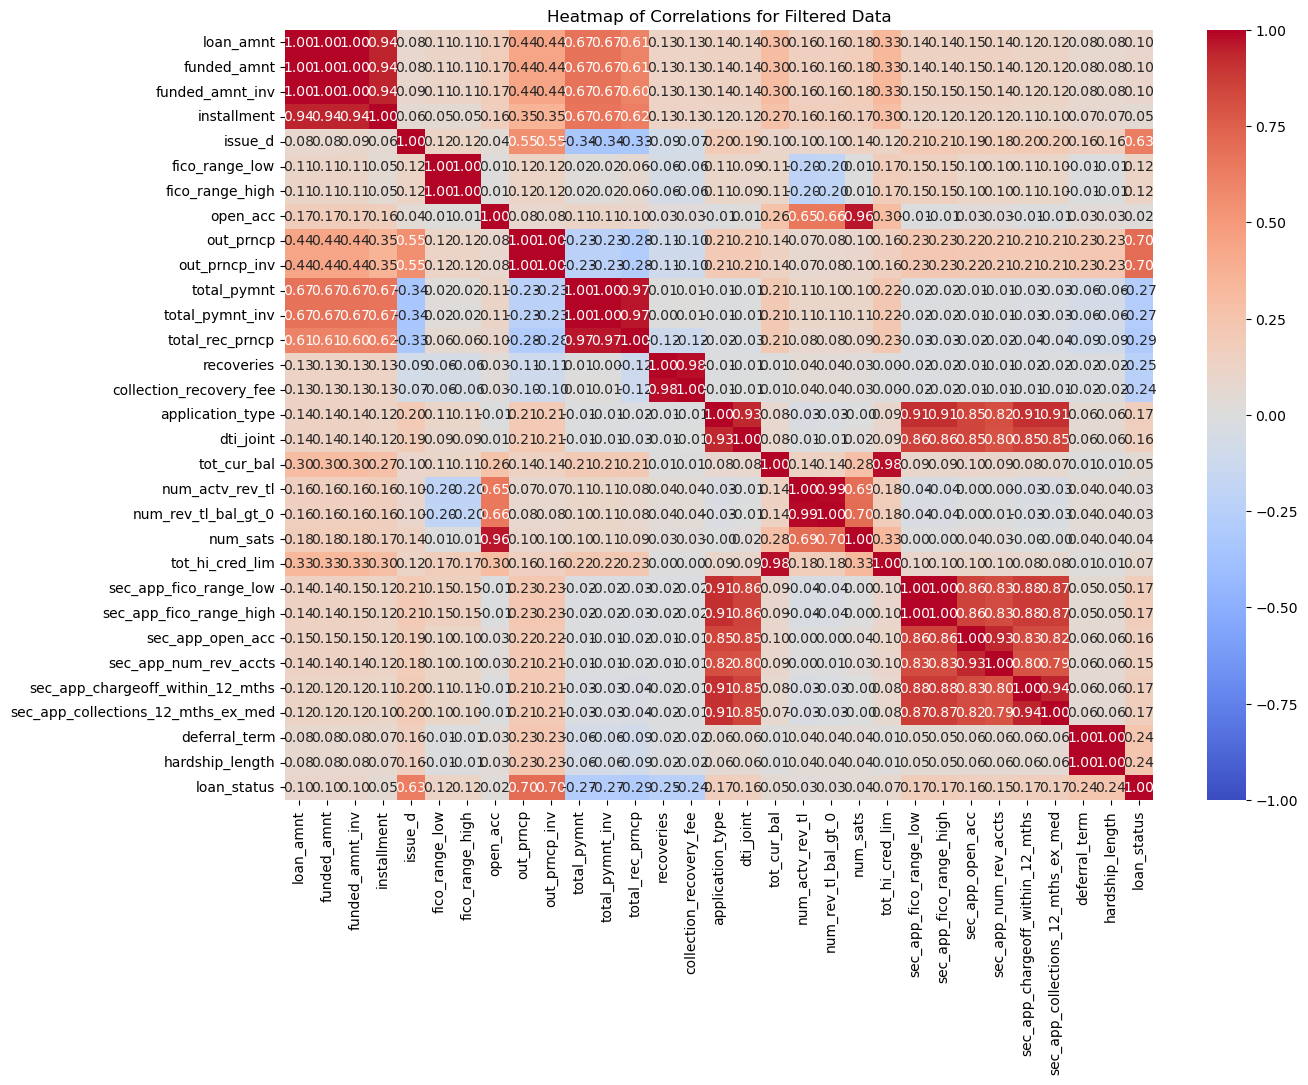

In [ ]:
threshold = 0.9
np.fill_diagonal(correlation.values, 0)
filtered_correlation = correlation[correlation.abs() > threshold]
filtered_correlation = filtered_correlation.dropna(how="all").dropna(axis=1, how="all")

high_corr_cols = correlation.columns[(correlation.abs() > threshold).any()].tolist()
if 'loan_status' not in high_corr_cols:
    high_corr_cols.append('loan_status')
irrelevant_fields = ['id']
high_corr_cols = [col for col in high_corr_cols if col not in irrelevant_fields]
filtered_data = data[high_corr_cols]
print(f"Columns kept (highly correlated): {high_corr_cols}")

filtered_correlation = filtered_data.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(filtered_correlation, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Heatmap of Correlations for Filtered Data")
plt.show()

# Highly Correlated Pairs (Positive Correlation):

loan_amnt, funded_amnt, funded_amnt_inv, and installment are strongly correlated (values above 0.94), indicating these features are closely related and likely capture similar information about the loan.
total_pymnt, total_pymnt_inv, and total_rec_prncp are also highly correlated (above 0.9), suggesting they all represent payment-related metrics.
fico_range_low and fico_range_high are strongly correlated (close to 1.0), reflecting they are likely different scales of the same credit score information.
num_actv_rev_tl and num_rev_tl_bal_gt_0 show a high correlation (~0.95), indicating they might represent active revolving credit accounts.
num_sats and tot_hi_cred_lim exhibit a strong correlation (~0.98), indicating they may be related to the total credit limits or accounts.

# Highly Correlated Pairs (Negative Correlation):

collection_recovery_fee and recoveries display strong negative correlations with some payment-related fields, such as total_pymnt or total_rec_prncp.

# Key Observations:

Features related to loan amount and installment tend to be highly interdependent.
Payment-related metrics (total_pymnt, total_rec_prncp, etc.) are strongly connected, which might introduce multicollinearity in models.
Features involving credit scores (fico_range_low, fico_range_high) are strongly correlated, suggesting redundancy.
Potential Redundancy:

Features with correlations close to 1 (e.g., loan_amnt and funded_amnt) or fico_range_low and fico_range_high might be redundant and can be removed or combined to reduce dimensionality.

In [ ]:
filtered_data.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'installment', 'issue_d',
       'fico_range_low', 'fico_range_high', 'open_acc', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'recoveries', 'collection_recovery_fee', 'application_type',
       'dti_joint', 'tot_cur_bal', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0',
       'num_sats', 'tot_hi_cred_lim', 'sec_app_fico_range_low',
       'sec_app_fico_range_high', 'sec_app_open_acc', 'sec_app_num_rev_accts',
       'sec_app_chargeoff_within_12_mths',
       'sec_app_collections_12_mths_ex_med', 'deferral_term',
       'hardship_length', 'loan_status'],
      dtype='object')

# Feature-target split

In [ ]:
X = data.drop("loan_status", axis=1)
y = data["loan_status"]
y = pd.factorize(y)[0]

# Train-test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Normalize features

In [ ]:
scaler = StandardScaler()
X_train = X_train.select_dtypes(include=['number'])
X_test = X_test.select_dtypes(include=['number'])
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SMOTE for oversampling

*Balancing the dataset by oversampling*

In [ ]:
# smote = SMOTE(random_state=42)
# X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Undersampling

In [ ]:
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train, y_train)

# Function to train and evaluate models

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

def evaluate_model_multiclass(model, X_train, y_train, X_test, y_test):
    # Binarize the labels for multiclass ROC calculation
    y_train_bin = label_binarize(y_train, classes=np.unique(y_train))
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    n_classes = y_train_bin.shape[1]
    
    # Train the model using OneVsRest strategy
    classifier = OneVsRestClassifier(model)
    classifier.fit(X_train, y_train_bin)

    # Predict probabilities
    y_proba = classifier.predict_proba(X_test)

    # Calculate ROC for each class
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (area = {roc_auc[i]:0.2f})")
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Multiclass")
    plt.legend(loc="lower right")
    plt.show()

    # Classification report
    y_pred = classifier.predict(X_test)
    print("Classification Report:\n", classification_report(y_test_bin, y_pred))


# Models to evaluate

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True, kernel='rbf', random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

# Evaluate models


Model: Logistic Regression (Multiclass Evaluation)


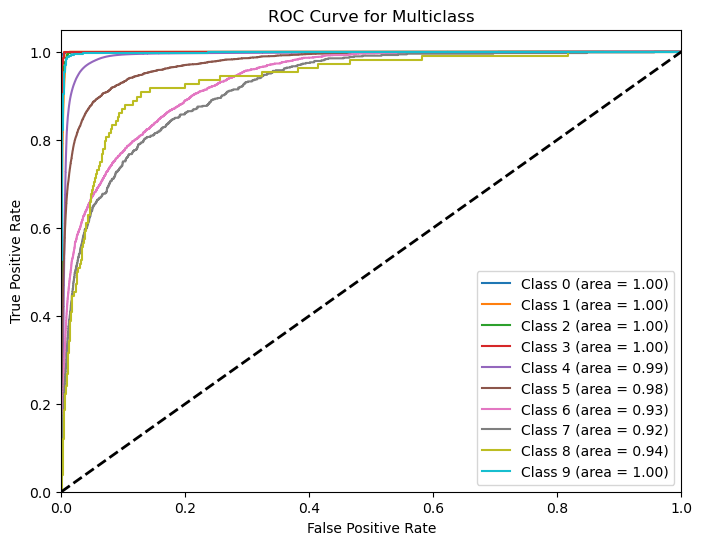

d:\applications\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     98418
           1       0.99      1.00      0.99    420020
           2       0.63      0.33      0.43       563
           3       0.59      0.30      0.40       213
           4       0.94      0.95      0.95    270954
           5       0.66      0.23      0.34      4055
           6       0.26      0.02      0.04      2612
           7       0.12      0.00      0.01       666
           8       0.00      0.00      0.00       108
           9       0.87      0.33      0.48       542

   micro avg       0.97      0.97      0.97    798151
   macro avg       0.61      0.42      0.46    798151
weighted avg       0.97      0.97      0.97    798151
 samples avg       0.97      0.97      0.97    798151


Model: SVM (Multiclass Evaluation)


In [ ]:
for model_name, model in models.items():
    print(f"\nModel: {model_name} (Multiclass Evaluation)")
    evaluate_model_multiclass(model, X_train, y_train, X_test, y_test)

# Evaluate models with undersampling

In [ ]:
for model_name, model in models.items():
    print(f"\nModel: {model_name} (Multiclass Evaluation)")
    evaluate_model_multiclass(model, X_train_under, y_train_under, X_test, y_test)

In [ ]:
# print("\nModel: Gradient Boosting with Undersampling")
# evaluate_model(GradientBoostingClassifier(random_state=42), X_train_under, y_train_under, X_test, y_test)

# Build ANN

In [ ]:
ann = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ann.fit(X_train_smote, y_train_smote, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=1)

# Evaluate ANN

In [ ]:
y_pred_ann = (ann.predict(X_test) > 0.5).astype(int)
print("\nClassification Report for ANN:\n", classification_report(y_test, y_pred_ann))